In [1]:
import os


# Import libraries from general conda environment
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy as copy
import pickle
from functools import reduce
from pathlib import Path

# Import libraries from UnitedNet
import sys
import os
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align

# Import for SHAPs
import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature

# Import for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

# Import for more detailed plotting
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter

# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx
import math
from scipy.spatial import distance
import anndata
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import gseapy

2025-10-20 21:14:25.194488: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 21:14:25.201879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-20 21:14:25.209841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-20 21:14:25.212246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-20 21:14:25.219076: I tensorflow/core/platform/cpu_feature_guar

# RNA

In [2]:
adata = sc.read_h5ad('../Data/perturbmap_stomicsdb/GSM5808055_10x_Visium_processed.h5ad')
adata

# Load phenotypic data
pheno = pd.read_csv("../Data/PertMap_metadata/spot_annotation_KP2.csv")
pheno = pheno.set_index("barcode")

# Add phenotypes to adata.obs
adata.obs["phenotypes"] = adata.obs.index.map(pheno["phenotypes"])
adata.obs['kmeans'] = adata.obs.index.map(pheno["kmeans"])

# Remove NA entries from phenotypes
adata_filtered = adata[adata.obs["phenotypes"].notna()].copy()

# Remove normal cells from phenotypes
adata_filtered = adata[(adata.obs["kmeans"] != "normal")].copy()
adata_filtered = adata_filtered[adata_filtered.obs["phenotypes"].notna()].copy()

In [3]:
adata_filtered

AnnData object with n_obs × n_vars = 483 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [4]:
sc.pp.normalize_total(adata_filtered, inplace=True)
sc.pp.log1p(adata_filtered)
sc.pp.highly_variable_genes(adata_filtered, flavor="seurat", n_top_genes=2000, subset=True)

In [5]:
sc.pp.pca(adata_filtered)
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered, key_added="clusters",  directed=False, n_iterations=2)

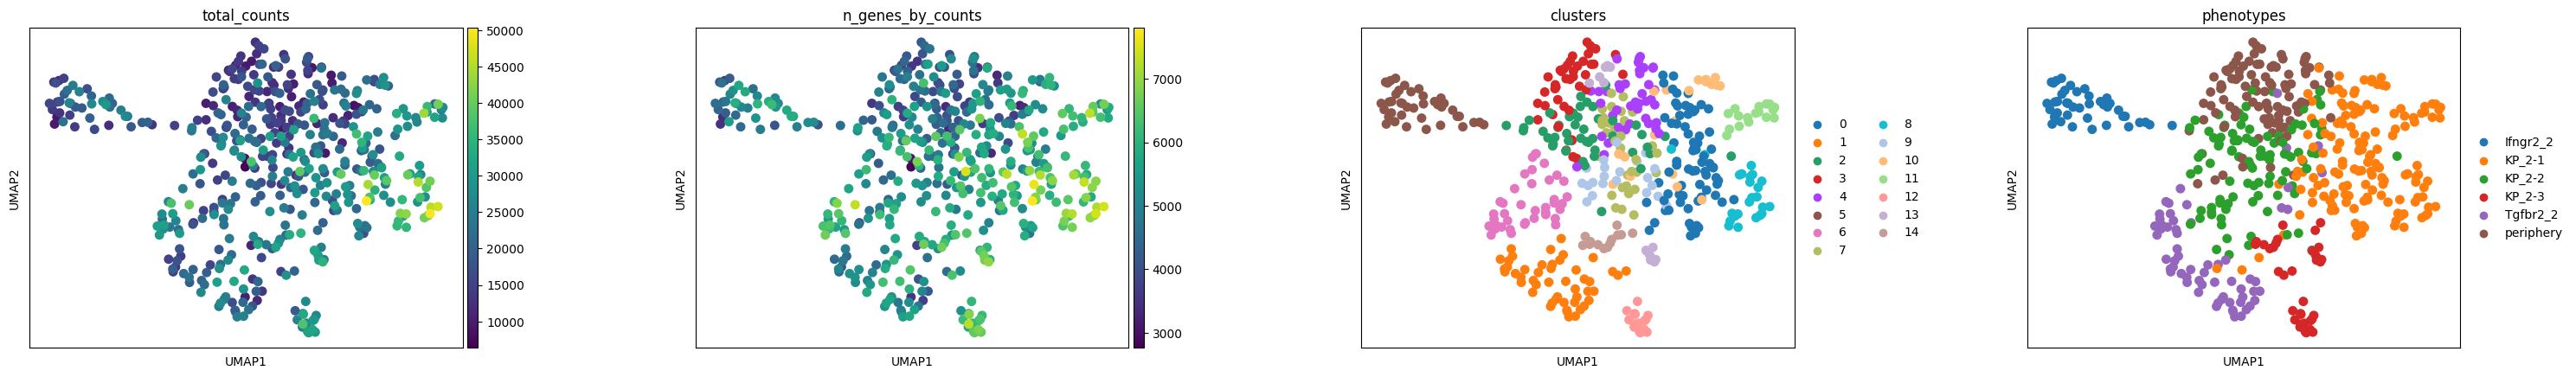

In [6]:
sc.pl.umap(adata_filtered, color=["total_counts", "n_genes_by_counts", "clusters", 'phenotypes'], wspace=0.4)

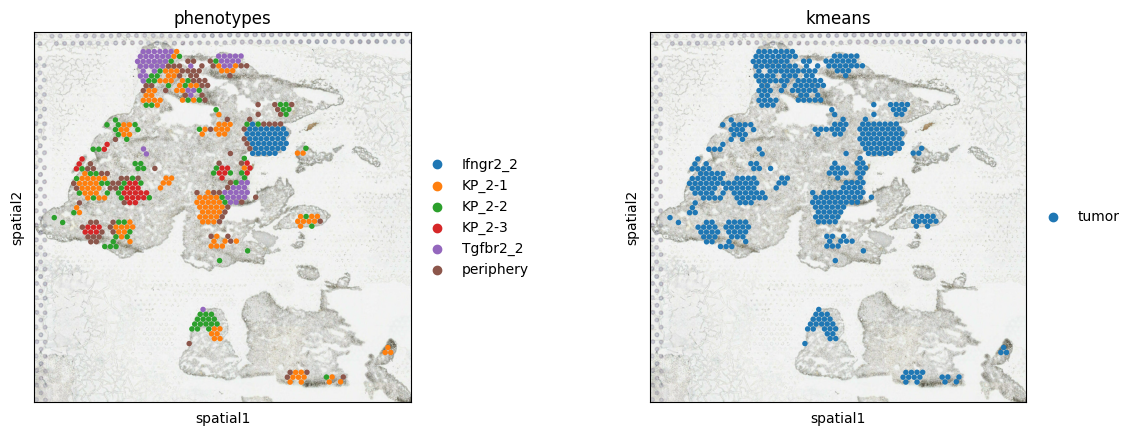

In [7]:
sc.pl.spatial(adata_filtered, img_key="hires", color=["phenotypes", 'kmeans'], size=1.5)

In [7]:
adata_filtered

AnnData object with n_obs × n_vars = 407 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p', 'phenotypes_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

# Niche

In [19]:
# same folder as your notebook
from niche_unitednet import run_niche_pipeline

niche = run_niche_pipeline(
    adata_in=adata_filtered,
    # output_path="../Data/processedData3/niche_modality.h5ad",
    k=15,
    distance_type="euclidean",
    weight_mode="inverse",   # or "uniform" / "gaussian"
    include_self=False,
    pheno_csv="../Data/PertMap_metadata/spot_annotation_KP2.csv",
    pheno_barcode_col="barcode",
    pheno_cols=["phenotypes", "kmeans"],
    # reference_adata_path='../Data/processedData3/rna_modality.h5ad',       # or "reference.h5ad"
    relabel_barcodes_to_reference=False,
    overwrite=True,
    log_level="INFO",
)
niche

2025-10-20 21:24:22,425 - INFO - Using provided AnnData object: (483, 2000)
2025-10-20 21:24:22,436 - INFO - Normalized barcodes.
2025-10-20 21:24:22,439 - INFO - Barcode overlap: 483 / 483 cells
2025-10-20 21:24:22,440 - INFO - Added phenotype column: phenotypes (483/483 cells matched, type: category)
2025-10-20 21:24:22,441 - INFO - Added phenotype column: kmeans (483/483 cells matched, type: category)
2025-10-20 21:24:22,453 - INFO - Computed 5803 edges (k=15, metric=euclidean).


X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 483 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p', 'phenotypes_colors', 'kmeans_colors', 'modality', 'niche_method'
    obsm: 'X_pca', 'X_umap', 'spatial'

# GSEAPY

## RNA

In [10]:
# minimal deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import dotplot

# ---- settings you will likely tweak ----
CASE        = "Tgfbr2_2"
CONTROLS    = ['KP_2-1', 'KP_2-2', 'KP_2-3', 'periphery']
GROUPBY     = "phenotypes"     # column in adata_filtered.obs
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more if you want, e.g. "KEGG_2021_Mouse"
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Slide2")
# ----------------------------------------

OUTDIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: DE + Enrichr")

    # 1) rank genes (t-test) for this comparison
    sc.tl.rank_genes_groups(
        adata_filtered,
        groupby=GROUPBY,
        groups=[CASE],               # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) extract and filter DEGs
    res_df = sc.get.rank_genes_groups_df(adata_filtered, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names","logfoldchanges","pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    # quick guard: if no genes pass, skip gracefully
    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) run Enrichr for each library and save outputs
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            # make a small dotplot (top 20 terms if available)
            if not enr_res.empty:
                # sort by Adjusted P-value if present
                sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else "P-value"
                enr_res_sorted = enr_res.sort_values(sort_col).head(20)
                ax = dotplot(
                    enr_res_sorted,
                    title=f"{lib} — {cmp_name} (RNA)",
                    cmap="viridis_r",
                    size=10,
                    figsize=(5,6)
                )
                figpath = run_dir / f"dotplot_{lib}.png"
                ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
                ax.figure.clf()

            # add to summary
            if not enr_res.empty:
                keep_cols = ["Term","Overlap","P-value","Adjusted P-value","Combined Score"]
                for _, row in enr_res.head(10).iterrows():  # top 10 per lib to keep summary small
                    summary_rows.append({
                        "comparison": cmp_name,
                        "library": lib,
                        "term": row.get("Term"),
                        "pval": row.get("P-value"),
                        "padj": row.get("Adjusted P-value"),
                        "combined_score": row.get("Combined Score"),
                        "overlap": row.get("Overlap")
                    })
        except Exception as e:
            print(f"[WARN] Enrichr failed for {cmp_name} :: {lib}: {e}")

# write a compact cross-comparison summary (optional)
if summary_rows:
    summary = pd.DataFrame(summary_rows)
    summary = summary.sort_values(["library","comparison","padj"], na_position="last")
    summary.to_csv(OUTDIR / "enrichr_summary_top10_per_library.csv", index=False)
    print(f"[OK] Summary saved: {OUTDIR/'enrichr_summary_top10_per_library.csv'}")
else:
    print("[WARN] No enrichment results collected.")

[INFO] Tgfbr2_2_vs_KP_2-1: DE + Enrichr
[INFO] Tgfbr2_2_vs_KP_2-2: DE + Enrichr
[INFO] Tgfbr2_2_vs_KP_2-3: DE + Enrichr
[INFO] Tgfbr2_2_vs_periphery: DE + Enrichr
[OK] Summary saved: GSEAPY_Enrichr_Only_Slide2/enrichr_summary_top10_per_library.csv


<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

In [11]:
# 2x2 grid composer for Enrichr dotplots
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_Slide2")
COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed KEGG etc.

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"dotplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

# If fewer than 4 comparisons, blank the remaining axes
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"dotplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# (optional) also a 1-page PDF
pdf_path = OUTDIR / f"dotplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Slide2/dotplots_2x2_BioPlanet_2019.png
2025-10-20 21:17:13,385 - INFO - maxp pruned
2025-10-20 21:17:13,390 - INFO - cmap pruned
2025-10-20 21:17:13,390 - INFO - kern dropped
2025-10-20 21:17:13,391 - INFO - post pruned
2025-10-20 21:17:13,391 - INFO - FFTM dropped
2025-10-20 21:17:13,392 - INFO - GPOS pruned
2025-10-20 21:17:13,394 - INFO - GSUB pruned
2025-10-20 21:17:13,397 - INFO - glyf pruned
2025-10-20 21:17:13,397 - INFO - Added gid0 to subset
2025-10-20 21:17:13,398 - INFO - Added first four glyphs to subset
2025-10-20 21:17:13,398 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-20 21:17:13,398 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:17:13,398 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-20 21:17

In [15]:
# --- RNA Enrichr + GSEApy barplot (simple & robust) ---
# deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import barplot
import matplotlib.pyplot as plt

# ---------------- settings ----------------
CASE        = "Tgfbr2_2"
CONTROLS    = ['KP_2-1', 'KP_2-2', 'KP_2-3', 'periphery']
GROUPBY     = "phenotypes"     # column in adata_filtered.obs
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more if you want, e.g. "KEGG_2021_Mouse"
TOP_N       = 20
OUTDIR      = Path("./GSEAPY_Enrichr_Only_RNA_Barplots_Slide2")
# adata_filtered: your RNA AnnData already in memory
# -------------------------------------------

# 0) ensure normalization/log1p (no-op if already normalized)
if "log1p" not in adata_filtered.uns:
    sc.pp.normalize_total(adata_filtered, target_sum=1e4)
    sc.pp.log1p(adata_filtered)

OUTDIR.mkdir(parents=True, exist_ok=True)

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: RNA DE + Enrichr (barplot)")

    # 1) DE: t-test case vs reference
    sc.tl.rank_genes_groups(
        adata_filtered,
        groupby=GROUPBY,
        groups=[CASE],         # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) collect DEGs @ FDR < ALPHA
    res_df = sc.get.rank_genes_groups_df(adata_filtered, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names","logfoldchanges","pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr + barplot per library
    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            if enr_res.empty:
                print(f"[WARN] No enrichment terms for {cmp_name} :: {lib}")
                continue

            # take top-N by Adjusted P-value (fallback to P-value)
            sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else (
                       "P-value" if "P-value" in enr_res.columns else None)
            plot_df = enr_res.copy()
            if sort_col:
                plot_df = plot_df.sort_values(sort_col, ascending=True).head(TOP_N)

            # barplot (same style you used)
            ax = barplot(
                plot_df,
                title=f"{lib} — {cmp_name} (RNA)",
                figsize=(4, 5),
                color="darkblue"
            )
            figpath = run_dir / f"barplot_{lib}.png"
            ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
            plt.close(ax.figure)
            print(f"[OK] Saved: {figpath}")

        except Exception as e:
            print(f"[WARN] Enrichr/barplot failed for {cmp_name} :: {lib}: {e}")

print("[OK] RNA barplots done.")


[INFO] Tgfbr2_2_vs_KP_2-1: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots_Slide2/Tgfbr2_2_vs_KP_2-1/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_KP_2-2: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots_Slide2/Tgfbr2_2_vs_KP_2-2/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_KP_2-3: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots_Slide2/Tgfbr2_2_vs_KP_2-3/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_periphery: RNA DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots_Slide2/Tgfbr2_2_vs_periphery/barplot_BioPlanet_2019.png
[OK] RNA barplots done.


In [16]:
# 2x2 grid composer for Enrichr BARPLOTS (RNA)
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_RNA_Barplots_Slide2")  # <-- RNA outputs

COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed other libs (e.g., "KEGG_2021_Mouse")

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"barplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"barplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- (optional) 1-page PDF ----
pdf_path = OUTDIR / f"barplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_RNA_Barplots_Slide2/barplots_2x2_BioPlanet_2019.png
2025-10-20 21:22:07,914 - INFO - maxp pruned
2025-10-20 21:22:07,919 - INFO - cmap pruned
2025-10-20 21:22:07,919 - INFO - kern dropped
2025-10-20 21:22:07,919 - INFO - post pruned
2025-10-20 21:22:07,919 - INFO - FFTM dropped
2025-10-20 21:22:07,921 - INFO - GPOS pruned
2025-10-20 21:22:07,923 - INFO - GSUB pruned
2025-10-20 21:22:07,926 - INFO - glyf pruned
2025-10-20 21:22:07,927 - INFO - Added gid0 to subset
2025-10-20 21:22:07,927 - INFO - Added first four glyphs to subset
2025-10-20 21:22:07,927 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-20 21:22:07,927 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:22:07,927 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
202

## Niche

In [20]:
# minimal deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import dotplot

# ---- settings ----
CASE        = "Tgfbr2_2"
CONTROLS    = ['KP_2-1', 'KP_2-2', 'KP_2-3', 'periphery']
GROUPBY     = "phenotypes"
ALPHA       = 0.05
LIBRARIES   = ["BioPlanet_2019"]  # add more (e.g., "KEGG_2021_Mouse")
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Niche_Slide2")
# ------------------

# (optional) quick normalization if your 'niche' object isn't log-normalized yet
if "log1p" not in niche.uns:
    sc.pp.normalize_total(niche, target_sum=1e4)
    sc.pp.log1p(niche)

OUTDIR.mkdir(parents=True, exist_ok=True)
summary_rows = []

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: Niche DE + Enrichr")

    # 1) rank genes (t-test) for this comparison
    sc.tl.rank_genes_groups(
        niche,
        groupby=GROUPBY,
        groups=[CASE],               # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) extract and filter DEGs
    res_df = sc.get.rank_genes_groups_df(niche, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names","logfoldchanges","pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr per library + dotplot
    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            # dotplot (top 20)
            if not enr_res.empty:
                sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else "P-value"
                enr_res_sorted = enr_res.sort_values(sort_col).head(20)
                ax = dotplot(
                    enr_res_sorted,
                    title=f"{lib} — {cmp_name} (Niche)",
                    cmap="viridis_r",
                    size=10,
                    figsize=(5,6)
                )
                figpath = run_dir / f"dotplot_{lib}.png"
                ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
                ax.figure.clf()

            # add to summary (top 10)
            if not enr_res.empty:
                for _, row in enr_res.head(10).iterrows():
                    summary_rows.append({
                        "comparison": cmp_name,
                        "library": lib,
                        "term": row.get("Term"),
                        "pval": row.get("P-value"),
                        "padj": row.get("Adjusted P-value"),
                        "combined_score": row.get("Combined Score"),
                        "overlap": row.get("Overlap")
                    })
        except Exception as e:
            print(f"[WARN] Enrichr failed for {cmp_name} :: {lib}: {e}")

# summary CSV
if summary_rows:
    summary = pd.DataFrame(summary_rows).sort_values(["library","comparison","padj"], na_position="last")
    summary.to_csv(OUTDIR / "enrichr_summary_top10_per_library.csv", index=False)
    print(f"[OK] Summary saved: {OUTDIR/'enrichr_summary_top10_per_library.csv'}")
else:
    print("[WARN] No enrichment results collected.")

[INFO] Tgfbr2_2_vs_KP_2-1: Niche DE + Enrichr
[INFO] Tgfbr2_2_vs_KP_2-2: Niche DE + Enrichr
[INFO] Tgfbr2_2_vs_KP_2-3: Niche DE + Enrichr
[INFO] Tgfbr2_2_vs_periphery: Niche DE + Enrichr
[OK] Summary saved: GSEAPY_Enrichr_Only_Niche_Slide2/enrichr_summary_top10_per_library.csv


<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

In [21]:
# 2x2 grid composer for Enrichr dotplots
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

OUTDIR = Path("./GSEAPY_Enrichr_Only_Niche_Slide2")
COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
LIB = "BioPlanet_2019"  # change if you composed KEGG etc.

def img_path(cmp_name, lib=LIB):
    p = OUTDIR / cmp_name / f"dotplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

# If fewer than 4 comparisons, blank the remaining axes
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"dotplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# (optional) also a 1-page PDF
pdf_path = OUTDIR / f"dotplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Niche_Slide2/dotplots_2x2_BioPlanet_2019.png
2025-10-20 21:25:19,928 - INFO - maxp pruned
2025-10-20 21:25:19,932 - INFO - cmap pruned
2025-10-20 21:25:19,933 - INFO - kern dropped
2025-10-20 21:25:19,933 - INFO - post pruned
2025-10-20 21:25:19,933 - INFO - FFTM dropped
2025-10-20 21:25:19,934 - INFO - GPOS pruned
2025-10-20 21:25:19,936 - INFO - GSUB pruned
2025-10-20 21:25:19,939 - INFO - glyf pruned
2025-10-20 21:25:19,940 - INFO - Added gid0 to subset
2025-10-20 21:25:19,940 - INFO - Added first four glyphs to subset
2025-10-20 21:25:19,940 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-20 21:25:19,940 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:25:19,941 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2025-10-20

In [22]:
# --- Niche Enrichr + GSEApy barplot (simple & robust) ---
# deps: scanpy, gseapy, pandas, matplotlib
import scanpy as sc
import pandas as pd
from pathlib import Path
import gseapy as gp
from gseapy import barplot
import matplotlib.pyplot as plt

# ---------------- settings ----------------
CASE        = "Tgfbr2_2"
CONTROLS    = ['KP_2-1', 'KP_2-2', 'KP_2-3', 'periphery']
GROUPBY     = "phenotypes"
ALPHA       = 0.05
TOP_N       = 20                       # top terms to show in the barplot
LIBRARIES   = ["BioPlanet_2019"]       # e.g., add "KEGG_2021_Mouse" or "KEGG_2021_Human"
OUTDIR      = Path("./GSEAPY_Enrichr_Only_Niche_Barplots_Slide2")
# niche: your AnnData object (already loaded) must be named `niche`
# -------------------------------------------

# 0) ensure normalization/log1p (no-op if already normalized)
if "log1p" not in niche.uns:
    sc.pp.normalize_total(niche, target_sum=1e4)
    sc.pp.log1p(niche)

OUTDIR.mkdir(parents=True, exist_ok=True)

for ctrl in CONTROLS:
    cmp_name = f"{CASE}_vs_{ctrl}"
    print(f"[INFO] {cmp_name}: Niche DE + Enrichr (barplot)")

    # 1) DE: t-test case vs reference
    sc.tl.rank_genes_groups(
        niche,
        groupby=GROUPBY,
        groups=[CASE],         # must be a sequence
        reference=ctrl,
        method="t-test",
        use_raw=False,
        tie_correct=True
    )

    # 2) collect DEGs @ FDR < ALPHA
    res_df = sc.get.rank_genes_groups_df(niche, group=CASE)
    de_df  = res_df.loc[res_df["pvals_adj"] < ALPHA, ["names","logfoldchanges","pvals_adj"]].copy()
    genes  = de_df["names"].dropna().drop_duplicates().tolist()

    run_dir = OUTDIR / cmp_name
    run_dir.mkdir(parents=True, exist_ok=True)
    de_df.to_csv(run_dir / "DEGs_padj_lt_0.05.csv", index=False)

    if len(genes) == 0:
        print(f"[WARN] No DEGs at padj<{ALPHA} for {cmp_name}. Skipping Enrichr.")
        continue

    # 3) Enrichr + barplot per library
    for lib in LIBRARIES:
        try:
            enr = gp.enrichr(gene_list=genes, gene_sets=lib, cutoff=ALPHA)
            enr_res = enr.results if hasattr(enr, "results") else pd.DataFrame()

            # save table
            res_csv = run_dir / f"enrichr_{lib}.csv"
            enr_res.to_csv(res_csv, index=False)

            if enr_res.empty:
                print(f"[WARN] No enrichment terms for {cmp_name} :: {lib}")
                continue

            # take top-N by Adjusted P-value (fallback to P-value)
            sort_col = "Adjusted P-value" if "Adjusted P-value" in enr_res.columns else (
                       "P-value" if "P-value" in enr_res.columns else None)
            plot_df = enr_res.copy()
            if sort_col:
                plot_df = plot_df.sort_values(sort_col, ascending=True).head(TOP_N)

            # barplot (your style)
            ax = barplot(
                plot_df,
                title=f"{lib} — {cmp_name} (Niche)",
                figsize=(4, 5),
                color="darkred"
            )
            figpath = run_dir / f"barplot_{lib}.png"
            ax.figure.savefig(figpath, dpi=200, bbox_inches="tight")
            plt.close(ax.figure)
            print(f"[OK] Saved: {figpath}")

        except Exception as e:
            print(f"[WARN] Enrichr/barplot failed for {cmp_name} :: {lib}: {e}")

print("[OK] Niche barplots done.")


[INFO] Tgfbr2_2_vs_KP_2-1: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots_Slide2/Tgfbr2_2_vs_KP_2-1/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_KP_2-2: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots_Slide2/Tgfbr2_2_vs_KP_2-2/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_KP_2-3: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots_Slide2/Tgfbr2_2_vs_KP_2-3/barplot_BioPlanet_2019.png
[INFO] Tgfbr2_2_vs_periphery: Niche DE + Enrichr (barplot)
[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots_Slide2/Tgfbr2_2_vs_periphery/barplot_BioPlanet_2019.png
[OK] Niche barplots done.


In [23]:
# 2x2 grid composer for Enrichr BARPLOTS (Niche)
# Requires: matplotlib, pillow (pip install pillow)
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

# If you used the code I gave for Niche barplots, use this OUTDIR:
OUTDIR = Path("./GSEAPY_Enrichr_Only_Niche_Barplots_Slide2")

COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
LIB = "BioPlanet_2019"  # change to "KEGG_2021_Mouse" etc. if needed

def img_path(cmp_name, lib=LIB):
    # NOTE: barplot filename pattern
    p = OUTDIR / cmp_name / f"barplot_{lib}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path is None:
        ax.text(
            0.5, 0.5, f"{title}\n(no plot)",
            ha="center", va="center", fontsize=11, color="gray",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
        )
    else:
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
        except Exception:
            ax.text(
                0.5, 0.5, f"{title}\n(load error)",
                ha="center", va="center", fontsize=11, color="gray",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="#f5f5f5", ec="#cccccc")
            )

# ---- make 2x2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)

for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTDIR / f"barplots_2x2_{LIB}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- (optional) 1-page PDF ----
pdf_path = OUTDIR / f"barplots_2x2_{LIB}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: GSEAPY_Enrichr_Only_Niche_Barplots_Slide2/barplots_2x2_BioPlanet_2019.png
2025-10-20 21:27:06,761 - INFO - maxp pruned
2025-10-20 21:27:06,765 - INFO - cmap pruned
2025-10-20 21:27:06,766 - INFO - kern dropped
2025-10-20 21:27:06,766 - INFO - post pruned
2025-10-20 21:27:06,766 - INFO - FFTM dropped
2025-10-20 21:27:06,767 - INFO - GPOS pruned
2025-10-20 21:27:06,769 - INFO - GSUB pruned
2025-10-20 21:27:06,772 - INFO - glyf pruned
2025-10-20 21:27:06,773 - INFO - Added gid0 to subset
2025-10-20 21:27:06,773 - INFO - Added first four glyphs to subset
2025-10-20 21:27:06,773 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-20 21:27:06,774 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:27:06,774 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 89, 92]
2

# BlitzGSEA

## RNA

In [24]:
# Batch BlitzGSEA -> dedicated output, plot ONLY "TGF-beta signaling pathway"
# deps: pandas, matplotlib, blitzgsea; your helper: logfc_formatter.convert_csv
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import blitzgsea as blitz
from logfc_formatter import convert_csv

# ------------ settings ------------
INDIR        = Path("./GSEAPY_Enrichr_Only_RNA_Barplots_Slide2")   # where the DEGs CSVs live (one subfolder per comparison)
INNAME       = "DEGs_padj_lt_0.05.csv"                      # filename to pick inside each comparison folder
LIBRARY      = "KEGG_2021_Human"
TARGET_TERM  = "TGF-beta signaling pathway"                 # the only pathway we will plot
OUTROOT      = Path("./BlitzGSEA_RNA_TGFbeta_only_Slide2")         # dedicated output root (separate from GSEApy dirs)
UPPERCASE    = True                                         # KEGG benefits from uppercase symbols
# -----------------------------------

OUTROOT.mkdir(parents=True, exist_ok=True)

# Load KEGG once
library = blitz.enrichr.get_library(LIBRARY)

def best_match_term(result_df, target):
    """Return the best matching term name from result_df for 'target' (case-insensitive).
    Tries exact match (ignore case), then substring, else returns None."""
    terms = result_df["term"].tolist() if "term" in result_df.columns else list(result_df.index)
    # exact (case-insensitive)
    for t in terms:
        if t.lower() == target.lower():
            return t
    # substring (case-insensitive)
    target_low = target.lower()
    candidates = [t for t in terms if target_low in t.lower()]
    if candidates:
        # if multiple, prefer the shortest (often the canonical KEGG title)
        return sorted(candidates, key=len)[0]
    return None

# Find all DEG CSVs
csv_files = sorted(INDIR.rglob(INNAME))
print(f"[INFO] Found {len(csv_files)} DEG CSVs under {INDIR.resolve()}.")

for csv_path in csv_files:
    tag = csv_path.parent.name        # e.g., "Tgfbr2_1_vs_KP_1-1"
    outdir = OUTROOT / tag
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"\n[INFO] {tag}: convert -> BlitzGSEA -> plot '{TARGET_TERM}'")

    # 1) Convert to signature ("0,1"), stripping _SIG/_TF & uppercasing for KEGG
    try:
        sig_csv = convert_csv(str(csv_path), uppercase=UPPERCASE)
    except Exception as e:
        print(f"[WARN] convert_csv failed for {csv_path}: {e}")
        continue

    # 2) Read signature and sort by score desc (column "1")
    try:
        sig = pd.read_csv(sig_csv)
        if not {"0","1"}.issubset(sig.columns):
            print(f"[WARN] {sig_csv} missing columns '0' and '1'; skipping.")
            continue
        sig = sig.dropna(subset=["0","1"]).sort_values("1", ascending=False).reset_index(drop=True)
        # Save the exact signature used
        used_sig_csv = outdir / "signature_used.csv"
        sig.to_csv(used_sig_csv, index=False)
    except Exception as e:
        print(f"[WARN] Could not load/sort signature for {sig_csv}: {e}")
        continue

    # 3) Run BlitzGSEA
    try:
        result = blitz.gsea(sig, library)   # result: DataFrame with columns incl. 'term', 'NES', 'pval', 'adj_pval' (when available)
        result_csv = outdir / f"blitzgsea_results_{LIBRARY.replace(' ','_')}.csv"
        result.to_csv(result_csv, index=False)
        print(f"[OK] Results saved: {result_csv}")
    except Exception as e:
        print(f"[WARN] blitz.gsea failed for {tag}: {e}")
        continue

    # 4) Only plot the target pathway (running-sum)
    term_to_plot = best_match_term(result, TARGET_TERM)
    if term_to_plot is None:
        print(f"[WARN] Target term not found in results for {tag}: '{TARGET_TERM}'")
        # optional: list a few suggestions
        suggestions = [t for t in (result['term'] if 'term' in result.columns else result.index) if 'tgf' in t.lower()]
        if suggestions:
            print("       Suggestions:", "; ".join(suggestions[:5]))
        continue

    try:
        fig_rs = blitz.plot.running_sum(sig, term_to_plot, library, result=result, compact=False, interactive_plot=False)
        safe_term = re.sub(r"[^A-Za-z0-9_.-]+", "_", term_to_plot)
        fig_rs.savefig(outdir / f"running_sum_{safe_term}.png", dpi=200, bbox_inches="tight")
        plt.close(fig_rs)
        print(f"[OK] Saved running-sum plot for: {term_to_plot}")
    except Exception as e:
        print(f"[WARN] running_sum failed for {tag} :: {term_to_plot}: {e}")

print("\n[DONE] BlitzGSEA batch (RNA) — only TGF-beta pathway plotted.")


[INFO] Found 4 DEG CSVs under /home/ggavriilidis/Mongoose/Scripts/GSEAPY_Enrichr_Only_RNA_Barplots_Slide2.

[INFO] Tgfbr2_2_vs_KP_2-1: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-1/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot for: TGF-beta signaling pathway

[INFO] Tgfbr2_2_vs_KP_2-2: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-2/blitzgsea_results_KEGG_2021_Human.csv
[WARN] Target term not found in results for Tgfbr2_2_vs_KP_2-2: 'TGF-beta signaling pathway'

[INFO] Tgfbr2_2_vs_KP_2-3: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_RNA_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-3/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot for: TGF-beta signaling pathway

[INFO] Tgfbr2_2_vs_periphery: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'


In [25]:
# 2×2 multipanel for BlitzGSEA running-sum figures
# deps: matplotlib, pillow
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# ----- settings -----
OUTROOT = Path("./BlitzGSEA_RNA_TGFbeta_only_Slide2")  # or "./BlitzGSEA_Niche_TGFbeta_only"
COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
TARGET_TERM = "TGF-beta signaling pathway"
# --------------------

def safe_term(term: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", term)

SAFE = safe_term(TARGET_TERM)

def img_path(cmp_name: str):
    p = OUTROOT / cmp_name / f"running_sum_{SAFE}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path and path.exists():
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
            return
        except Exception:
            pass
    ax.text(0.5, 0.5, f"{title}\n(no plot)", ha="center", va="center",
            fontsize=11, color="gray", transform=ax.transAxes)

# ---- make 2×2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTROOT / f"running_sum_2x2_{SAFE}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- optional: 1-page PDF ----
pdf_path = OUTROOT / f"running_sum_2x2_{SAFE}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: BlitzGSEA_RNA_TGFbeta_only_Slide2/running_sum_2x2_TGF-beta_signaling_pathway.png
2025-10-20 21:28:24,281 - INFO - maxp pruned
2025-10-20 21:28:24,285 - INFO - cmap pruned
2025-10-20 21:28:24,286 - INFO - kern dropped
2025-10-20 21:28:24,286 - INFO - post pruned
2025-10-20 21:28:24,286 - INFO - FFTM dropped
2025-10-20 21:28:24,288 - INFO - GPOS pruned
2025-10-20 21:28:24,289 - INFO - GSUB pruned
2025-10-20 21:28:24,293 - INFO - glyf pruned
2025-10-20 21:28:24,294 - INFO - Added gid0 to subset
2025-10-20 21:28:24,294 - INFO - Added first four glyphs to subset
2025-10-20 21:28:24,294 - INFO - Closing glyph list over 'MATH': 29 glyphs before
2025-10-20 21:28:24,294 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:28:24,295 - INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 20, 21, 22,

## Niche

In [26]:
# Batch BlitzGSEA (Niche) -> dedicated output, plot ONLY "TGF-beta signaling pathway"
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import blitzgsea as blitz
from logfc_formatter import convert_csv

# ------------ settings ------------
INDIR        = Path("./GSEAPY_Enrichr_Only_Niche_Barplots_Slide2")
INNAME       = "DEGs_padj_lt_0.05.csv"
LIBRARY      = "KEGG_2021_Human"
TARGET_TERM  = "TGF-beta signaling pathway"
OUTROOT      = Path("./BlitzGSEA_Niche_TGFbeta_only_Slide2")
UPPERCASE    = True
# -----------------------------------

OUTROOT.mkdir(parents=True, exist_ok=True)
library = blitz.enrichr.get_library(LIBRARY)

def best_match_term(result_df, target):
    terms = result_df["term"].tolist() if "term" in result_df.columns else list(result_df.index)
    for t in terms:
        if t.lower() == target.lower():
            return t
    tl = target.lower()
    cands = [t for t in terms if tl in t.lower()]
    return sorted(cands, key=len)[0] if cands else None

csv_files = sorted(INDIR.rglob(INNAME))
print(f"[INFO] Found {len(csv_files)} DEG CSVs under {INDIR.resolve()}.")

for csv_path in csv_files:
    tag = csv_path.parent.name
    outdir = OUTROOT / tag
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"\n[INFO] {tag}: convert -> BlitzGSEA -> plot '{TARGET_TERM}'")

    # 1) Convert to signature ("0,1")
    try:
        sig_csv = convert_csv(str(csv_path), uppercase=UPPERCASE)
    except Exception as e:
        print(f"[WARN] convert_csv failed for {csv_path}: {e}")
        continue

    # 2) Load & sort signature
    try:
        sig = pd.read_csv(sig_csv)
        if not {"0","1"}.issubset(sig.columns):
            print(f"[WARN] {sig_csv} missing columns '0' and '1'; skipping.")
            continue
        sig = sig.dropna(subset=["0","1"]).sort_values("1", ascending=False).reset_index(drop=True)
        used_sig_csv = outdir / "signature_used.csv"
        sig.to_csv(used_sig_csv, index=False)
    except Exception as e:
        print(f"[WARN] Could not load/sort signature for {sig_csv}: {e}")
        continue

    # 3) Run BlitzGSEA
    try:
        result = blitz.gsea(sig, library)
        result_csv = outdir / f"blitzgsea_results_{LIBRARY.replace(' ','_')}.csv"
        result.to_csv(result_csv, index=False)
        print(f"[OK] Results saved: {result_csv}")
    except Exception as e:
        print(f"[WARN] blitz.gsea failed for {tag}: {e}")
        continue

    # 4) Plot ONLY target pathway
    term_to_plot = best_match_term(result, TARGET_TERM)
    if term_to_plot is None:
        print(f"[WARN] Target term not found for {tag}: '{TARGET_TERM}'")
        suggestions = [t for t in (result['term'] if 'term' in result.columns else result.index) if 'tgf' in t.lower()]
        if suggestions:
            print("       Suggestions:", "; ".join(suggestions[:5]))
        continue

    try:
        fig = blitz.plot.running_sum(sig, term_to_plot, library, result=result, compact=False, interactive_plot=False)
        safe = re.sub(r"[^A-Za-z0-9_.-]+", "_", term_to_plot)
        out_png = outdir / f"running_sum_{safe}.png"
        fig.savefig(out_png, dpi=200, bbox_inches="tight")
        plt.close(fig)
        print(f"[OK] Saved running-sum plot: {out_png}")
    except Exception as e:
        print(f"[WARN] running_sum failed for {tag} :: {term_to_plot}: {e}")

print("\n[DONE] BlitzGSEA batch (Niche) — only TGF-beta pathway plotted.")


[INFO] Found 4 DEG CSVs under /home/ggavriilidis/Mongoose/Scripts/GSEAPY_Enrichr_Only_Niche_Barplots_Slide2.

[INFO] Tgfbr2_2_vs_KP_2-1: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-1/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_Niche_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-1/running_sum_TGF-beta_signaling_pathway.png

[INFO] Tgfbr2_2_vs_KP_2-2: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-2/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_Niche_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-2/running_sum_TGF-beta_signaling_pathway.png

[INFO] Tgfbr2_2_vs_KP_2-3: convert -> BlitzGSEA -> plot 'TGF-beta signaling pathway'
[OK] Results saved: BlitzGSEA_Niche_TGFbeta_only_Slide2/Tgfbr2_2_vs_KP_2-3/blitzgsea_results_KEGG_2021_Human.csv
[OK] Saved running-sum plot: BlitzGSEA_N

In [27]:
# 2×2 multipanel for BlitzGSEA running-sum figures (Niche)
# deps: matplotlib, pillow
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# ----- settings (Niche) -----
OUTROOT = Path("./BlitzGSEA_Niche_TGFbeta_only_Slide2")
COMPARISONS = [
    "Tgfbr2_2_vs_KP_2-1",
    "Tgfbr2_2_vs_KP_2-2",
    "Tgfbr2_2_vs_KP_2-3",
    "Tgfbr2_2_vs_periphery",
]
TARGET_TERM = "TGF-beta signaling pathway"
# ----------------------------

def safe_term(term: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", term)

SAFE = safe_term(TARGET_TERM)

def img_path(cmp_name: str):
    p = OUTROOT / cmp_name / f"running_sum_{SAFE}.png"
    return p if p.exists() else None

def add_panel(ax, path, title):
    ax.axis("off")
    if path and path.exists():
        try:
            ax.imshow(Image.open(path))
            ax.set_title(title, fontsize=12, pad=6)
            return
        except Exception:
            pass
    ax.text(0.5, 0.5, f"{title}\n(no plot)", ha="center", va="center",
            fontsize=11, color="gray", transform=ax.transAxes)

# ---- make 2×2 grid (PNG) ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, cmp_name in zip(axes, COMPARISONS):
    add_panel(ax, img_path(cmp_name), title=cmp_name)
for k in range(len(COMPARISONS), 4):
    axes[k].axis("off")

out_png = OUTROOT / f"running_sum_2x2_{SAFE}.png"
fig.tight_layout()
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"[OK] Saved: {out_png}")

# ---- optional: 1-page PDF ----
pdf_path = OUTROOT / f"running_sum_2x2_{SAFE}.pdf"
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for ax, cmp_name in zip(axes, COMPARISONS):
        add_panel(ax, img_path(cmp_name), title=cmp_name)
    for k in range(len(COMPARISONS), 4):
        axes[k].axis("off")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)
print(f"[OK] Saved: {pdf_path}")


[OK] Saved: BlitzGSEA_Niche_TGFbeta_only_Slide2/running_sum_2x2_TGF-beta_signaling_pathway.png
2025-10-20 21:30:05,363 - INFO - maxp pruned
2025-10-20 21:30:05,367 - INFO - cmap pruned
2025-10-20 21:30:05,368 - INFO - kern dropped
2025-10-20 21:30:05,368 - INFO - post pruned
2025-10-20 21:30:05,368 - INFO - FFTM dropped
2025-10-20 21:30:05,369 - INFO - GPOS pruned
2025-10-20 21:30:05,371 - INFO - GSUB pruned
2025-10-20 21:30:05,375 - INFO - glyf pruned
2025-10-20 21:30:05,375 - INFO - Added gid0 to subset
2025-10-20 21:30:05,375 - INFO - Added first four glyphs to subset
2025-10-20 21:30:05,375 - INFO - Closing glyph list over 'MATH': 23 glyphs before
2025-10-20 21:30:05,376 - INFO - Glyph names: ['.notdef', '.null', 'K', 'P', 'T', 'b', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'nonmarkingreturn', 'one', 'p', 'r', 's', 'space', 'three', 'two', 'underscore', 'v', 'y']
2025-10-20 21:30:05,376 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 46, 51, 55, 66, 69, 72, 73, 74, 75, 76, 83, 85, 86, 